In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [25]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.dropout(F.relu(self.fc1(x)), p = 0.5) + torch.sin(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [73]:
def train_net(x_train, y_train, epochs = 2000, lr = 0.001, momentum = 0.9):
    
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(net.parameters(), lr = lr)
    
    try:   
        for epoch in range(epochs):

            y_pred = net(x_train)

            loss = criterion(y_pred, y_train)

            epoch_loss = loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 500 == 0:
                print('epoch {}, loss {}'.format(epoch, epoch_loss))
                
    except KeyboardInterrupt:
        return net
    
    with torch.no_grad():
        y_pred = net(x_train)
        
        plt.scatter(x_train, y_train, label = 'True')
        plt.scatter(x_train, y_pred, label = 'Predicted')
        plt.legend()
        plt.grid()
        plt.show()
    
    return net

In [27]:
def show_results(net, x_test, y_test):
    
    with torch.no_grad():
        y_pred_test = net(x_test).numpy()
        y_test = y_test.numpy()
        x_test = x_test.numpy()

        plt.scatter(x_test, y_pred_test, label = 'Predicted', s = 10)
        plt.scatter(x_test, y_test, label = 'True', s = 10)
        plt.xlabel('Seconds (s)')
        plt.ylabel('Heart Rate (bpm)')
        plt.grid()
        plt.legend()
        plt.show

In [28]:
def train_test_split(x, y, test = 0.2, shuffle = True):
    
    n = len(x)
    
    indices = np.arange(n)
    
    if shuffle:
        np.random.shuffle(indices)
    
    train_split = 1 - test
    ntrain = int(len(x) * train_split)
    
    train_indices, test_indices = indices[:ntrain], indices[ntrain:]
    
    x_train, x_test = x[train_indices], x[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return x_train, x_test, y_train, y_test

In [29]:
def makeData(npoints = 500, f = None):
    
    if f is None:
        f = lambda x: x*x + 10
    
    x = np.random.rand(npoints) * 40 - 20
    
    y = np.array(list(map(f, x)))
    
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    
    return x, y

In [30]:
def plot_helper(x, y, label = 'Data'):
    plt.scatter(x, y, label = label, s = 10)
    plt.legend()
    plt.show()

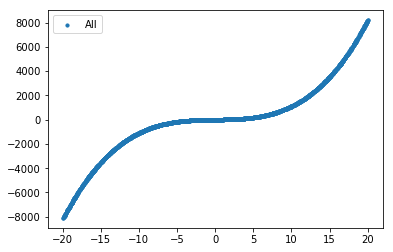

In [79]:
#x, y = makeData(2000, f = lambda x: np.sin(x))
x, y = makeData(2000, f = lambda x: x**3 + 10*x)
plot_helper(x, y, 'All')

x_train, x_test, y_train, y_test = train_test_split(x, y)

#plot_helper(x_train, y_train, 'Training')

#plot_helper(x_test, y_test, "Testing")

epoch 0, loss 2026.432373046875
epoch 500, loss 1742.540771484375
epoch 1000, loss 1202.153564453125
epoch 1500, loss 1065.2950439453125
epoch 2000, loss 1057.06884765625
epoch 2500, loss 1049.912109375
epoch 3000, loss 973.0352172851562
epoch 3500, loss 891.8345336914062
epoch 4000, loss 880.7561645507812
epoch 4500, loss 856.3347778320312


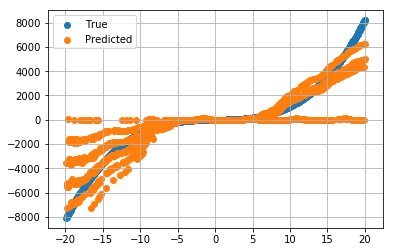

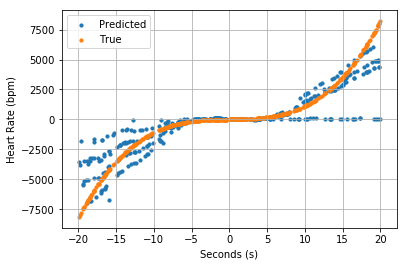

In [80]:
net = train_net(x_train, y_train, epochs = 5000, lr = 0.001)
show_results(net, x_test, y_test)

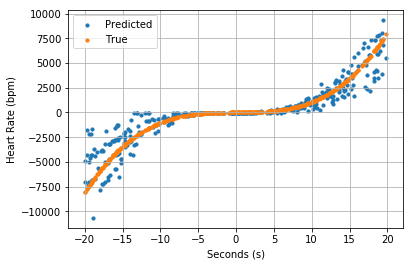

In [33]:
show_results(net, x_test, y_test)

In [34]:
df = pd.read_csv('heart_rate_data.csv')

In [35]:
df.head()

,Time,Value
0,10/1/17 0:00,57
1,10/1/17 0:00,58
2,10/1/17 0:00,58
3,10/1/17 0:00,58
4,10/1/17 0:00,58


In [36]:
t = np.arange(len(df))
df['Time'] = t
df.head()

,Time,Value
0,0,57
1,1,58
2,2,58
3,3,58
4,4,58


In [37]:
x = torch.Tensor(df['Time'].values).view(-1, 1)
y = torch.Tensor(df['Value'].values).view(-1, 1)

In [18]:
len(df)

122247

In [38]:
npts = 100
x_train, x_test, y_train, y_test = train_test_split(x[:npts], y[:npts], shuffle = False)

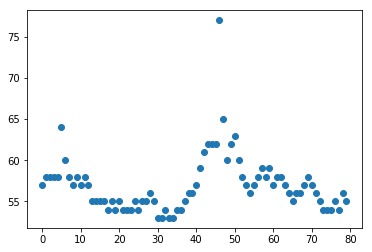

In [39]:
plt.scatter(x_train.numpy()[:100], y_train.numpy()[:100])

epoch 0, loss 52.694190979003906
epoch 500, loss 25.893932342529297
epoch 1000, loss 16.61927604675293
epoch 1500, loss 10.857358932495117
epoch 2000, loss 8.557637214660645
epoch 2500, loss 7.176825046539307
epoch 3000, loss 7.067275047302246
epoch 3500, loss 6.119318962097168


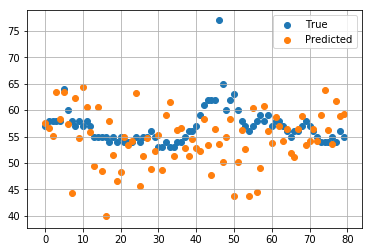

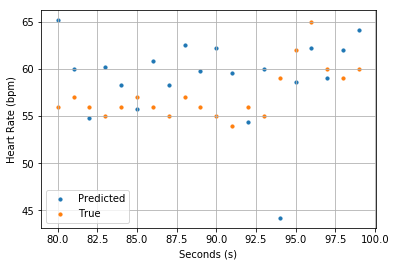

In [42]:
net = train_net(x_train, y_train, epochs = 4000, lr = 0.001)
show_results(net, x_test, y_test)

#### A regular neural network is not suitable for time series predictions, now to try an RNN

In [62]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

In [63]:
sequence_length = 28
input_size = 79
hidden_size = 50
num_layers = 2
num_classes = 1
batch_size = 32
num_epochs = 500
learning_rate = 0.001

rnn = RNN(input_size, hidden_size, num_layers, num_classes)

In [64]:
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(rnn.parameters(), lr = learning_rate)

In [65]:
x_train, y_train = y_train[:-1], y_train[1:]

In [66]:
x_test, y_test = y_test[:-1], y_test[1:]

In [67]:
train_net(rnn, x_train, y_train)

RuntimeError: input must have 3 dimensions, got 2